# Results Viewer

## Plot Metrics

### Setup & configuration

In [ ]:

import re
import math
import requests
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.pyplot as plt

from pathlib import Path

In [ ]:

# ======== CONFIG ========
# go to the directory where the results are stored
# 
BASE_PATH = Path("./data")


### Functions

In [58]:
def parse_overall_metrics(block: str) -> dict:
    """
    Extract overall metrics from a text block:
      AUC, MCC, Kappa, F1, Accuracy, Sensitivity, Specificity, PPV, NPV, Balanced Accuracy
    """
    def grab(name: str):
        m = re.search(rf"\b{name}:\s*([0-9.]+)", block)
        return float(m.group(1)) if m else math.nan

    return {
        "AUC": grab("AUC"),
        "MCC": grab("MCC"),
        "Kappa": grab("Kappa"),
        "F1": grab("F1"),
        "Accuracy": grab("Accuracy"),
        "Sensitivity": grab("Sensitivity"),
        "Specificity": grab("Specificity"),
        "PPV": grab("PPV"),
        "NPV": grab("NPV"),
        "Balanced_Accuracy": grab("Balanced Accuracy"),
    }


def parse_classification_report(block: str) -> list[dict]:
    """
    Parse a scikit-learn-like classification report section into rows:
      class, precision, recall, f1, support

    Expected lines like:
        0.0       0.69      0.68      0.68        37
        1.0       0.56      0.58      0.57        26
    """
    rows = []
    pattern = (
        r"^\s*(?P<class>[01](?:\.0)?)\s+"
        r"(?P<precision>[0-9.]+)\s+"
        r"(?P<recall>[0-9.]+)\s+"
        r"(?P<f1>[0-9.]+)\s+"
        r"(?P<support>\d+)\s*$"
    )
    for m in re.finditer(pattern, block, flags=re.M):
        rows.append({
            "Class": m.group("class"),
            "Precision": float(m.group("precision")),
            "Recall": float(m.group("recall")),
            "F1": float(m.group("f1")),
            "Support": int(m.group("support")),
        })
    return rows


def safe_read(path: Path) -> str | None:
    try:
        return path.read_text(encoding="utf-8")
    except Exception:
        return None


def results_label(dir_name: str) -> str | None:
    """
    Extract the label from a directory name like: results_<LABEL>_ratio  ->  <LABEL>
    (LABEL can be a number like '12' or text like 'p-value')
    """
    m = re.fullmatch(r"results_(.+?)_ratio", dir_name)
    return m.group(1) if m else None


def sort_key_by_label(dir_name: str) -> tuple[int, float | str]:
    """
    Sort key: numeric labels by value, then textual labels alphabetically.
    """
    lbl = results_label(dir_name)
    if lbl is None:
        return (2, dir_name.lower())
    try:
        return (1, float(lbl))  # numeric
    except Exception:
        return (0, lbl.lower())  # text

### Enumerate experiments (ordered) & build categorical X-axis

In [59]:
all_folders = [
    d.name for d in BASE_PATH.iterdir()
    if d.is_dir() and d.name.startswith("results_") and d.name.endswith("_ratio")
]
folders_sorted = sorted(all_folders, key=sort_key_by_label)

experiment_labels = [results_label(f) for f in folders_sorted]
pos_map = {lab: i + 1 for i, lab in enumerate(experiment_labels)}  # 1..N positions for plotting

experiment_labels[:5], list(pos_map.items())[:5]

(['0.009', '0.01', '0.02', '0.03', '0.04'],
 [('0.009', 1), ('0.01', 2), ('0.02', 3), ('0.03', 4), ('0.04', 5)])

### Parse all reports into tidy tables

In [60]:
overall_records: list[dict] = []
perclass_records: list[dict] = []

for folder in folders_sorted:
    report_path = (
        BASE_PATH / folder / "most_discriminant" / "radiomics_experiment" /
        "best_results" / "report.txt"
    )
    content = safe_read(report_path)
    if not content:
        continue

    exp_name = folder
    exp_label = results_label(folder)
    exp_pos = pos_map.get(exp_label, None)

    # --- key sections ---

    # Test (NOT calibrated)
    m_test = re.search(
        r"===\s*Evaluación en Test \(NO calibrado\)\s*===(.*?)(?:(?:===)|\Z)",
        content, flags=re.S
    )
    test_block = m_test.group(1) if m_test else ""

    # Classification Report (NOT calibrated)
    m_clf_test = re.search(
        r"===\s*Classification Report\s*===(.*?)(?:(?:===)|\Z)",
        content, flags=re.S
    )
    clf_test_block = m_clf_test.group(1) if m_clf_test else ""

    # Threshold tuning: capture the classification report block after threshold header
    m_thr_section = re.search(
        r"===\s*Ajuste de Umbral.*?===\s*Resultados.*?(?:(?:Classification Report.*threshold.*?:\s*)(.*?))AUC:",
        content, flags=re.S
    )
    clf_thr_block = m_thr_section.group(1) if m_thr_section else ""

    # Best threshold value
    m_best_thr = re.search(r"Mejor threshold.*?:\s*([0-9.]+)", content)
    best_threshold = float(m_best_thr.group(1)) if m_best_thr else math.nan

    # Overall metrics: (NOT calibrated)
    overall_test = parse_overall_metrics(test_block)
    overall_test.update({
        "Experiment": exp_name,
        "Experiment_Label": exp_label,
        "Experiment_Pos": exp_pos,
        "Section": "Test_NotCalibrated",
        "Best_Threshold": math.nan
    })
    overall_records.append(overall_test)

    # Overall metrics: (Best threshold) — parse after the threshold classification report
    m_after_thr = re.search(
        r"(Classification Report \(con threshold[^\n]*\):.*)", content, flags=re.S
    )
    if m_after_thr:
        after_thr_block = m_after_thr.group(1)
        m_thr_metrics = re.search(
            r"AUC:\s*[0-9.].*?(?:Balanced Accuracy:\s*[0-9.]+)",
            after_thr_block, flags=re.S
        )
        thr_metrics_block = m_thr_metrics.group(0) if m_thr_metrics else ""
        overall_thr = parse_overall_metrics(thr_metrics_block)
        overall_thr.update({
            "Experiment": exp_name,
            "Experiment_Label": exp_label,
            "Experiment_Pos": exp_pos,
            "Section": "Best_Threshold",
            "Best_Threshold": best_threshold
        })
        overall_records.append(overall_thr)

    # Per-class (NOT calibrated)
    for row in parse_classification_report(clf_test_block):
        row.update({
            "Experiment": exp_name,
            "Experiment_Label": exp_label,
            "Experiment_Pos": exp_pos,
            "Section": "Test_NotCalibrated",
            "Best_Threshold": math.nan
        })
        perclass_records.append(row)

    # Per-class (Best threshold)
    for row in parse_classification_report(clf_thr_block):
        row.update({
            "Experiment": exp_name,
            "Experiment_Label": exp_label,
            "Experiment_Pos": exp_pos,
            "Section": "Best_Threshold",
            "Best_Threshold": best_threshold
        })
        perclass_records.append(row)

len(overall_records), len(perclass_records)


(34, 68)

### Build DataFrames & quick peek

In [61]:
df_overall = pd.DataFrame(overall_records).sort_values(["Experiment_Pos", "Section"])
df_perclass = pd.DataFrame(perclass_records).sort_values(["Experiment_Pos", "Section", "Class"])

print("=== OVERALL METRICS ===")
display(df_overall.head(10))

print("\n=== PER-CLASS METRICS ===")
display(df_perclass.head(10))


=== OVERALL METRICS ===


,AUC,MCC,Kappa,F1,Accuracy,Sensitivity,Specificity,PPV,NPV,Balanced_Accuracy,Experiment,Experiment_Label,Experiment_Pos,Section,Best_Threshold
1,0.884,0.633,0.633,0.792,0.820,0.808,0.829,0.778,0.853,0.818,results_0.009_ratio,0.009,1,Best_Threshold,0.5
0,0.890,0.611,0.606,0.786,0.803,0.846,0.771,0.733,0.871,0.809,results_0.009_ratio,0.009,1,Test_NotCalibrated,NaN
3,0.886,0.665,0.665,0.808,0.836,0.808,0.857,0.808,0.857,0.832,results_0.01_ratio,0.01,2,Best_Threshold,0.5
2,0.898,0.573,0.571,0.764,0.787,0.808,0.771,0.724,0.844,0.790,results_0.01_ratio,0.01,2,Test_NotCalibrated,NaN
5,0.911,0.697,0.697,0.824,0.852,0.808,0.886,0.840,0.861,0.847,results_0.02_ratio,0.02,3,Best_Threshold,0.5
4,0.909,0.633,0.633,0.792,0.820,0.808,0.829,0.778,0.853,0.818,results_0.02_ratio,0.02,3,Test_NotCalibrated,NaN
7,0.869,0.573,0.571,0.764,0.787,0.808,0.771,0.724,0.844,0.790,results_0.03_ratio,0.03,4,Best_Threshold,0.4
6,0.873,0.573,0.571,0.764,0.787,0.808,0.771,0.724,0.844,0.790,results_0.03_ratio,0.03,4,Test_NotCalibrated,NaN
9,0.876,0.602,0.532,0.776,0.754,1.000,0.571,0.634,1.000,0.786,results_0.04_ratio,0.04,5,Best_Threshold,0.2
8,0.865,0.562,0.562,0.745,0.787,0.731,0.829,0.760,0.806,0.780,results_0.04_ratio,0.04,5,Test_NotCalibrated,NaN



=== PER-CLASS METRICS ===


,Class,Precision,Recall,F1,Support,Experiment,Experiment_Label,Experiment_Pos,Section,Best_Threshold
2,0.0,0.85,0.83,0.84,35,results_0.009_ratio,0.009,1,Best_Threshold,0.5
3,1.0,0.78,0.81,0.79,26,results_0.009_ratio,0.009,1,Best_Threshold,0.5
0,0.0,0.87,0.77,0.82,35,results_0.009_ratio,0.009,1,Test_NotCalibrated,NaN
1,1.0,0.73,0.85,0.79,26,results_0.009_ratio,0.009,1,Test_NotCalibrated,NaN
6,0.0,0.86,0.86,0.86,35,results_0.01_ratio,0.01,2,Best_Threshold,0.5
7,1.0,0.81,0.81,0.81,26,results_0.01_ratio,0.01,2,Best_Threshold,0.5
4,0.0,0.84,0.77,0.81,35,results_0.01_ratio,0.01,2,Test_NotCalibrated,NaN
5,1.0,0.72,0.81,0.76,26,results_0.01_ratio,0.01,2,Test_NotCalibrated,NaN
10,0.0,0.86,0.89,0.87,35,results_0.02_ratio,0.02,3,Best_Threshold,0.5
11,1.0,0.84,0.81,0.82,26,results_0.02_ratio,0.02,3,Best_Threshold,0.5


### Save tables (TSV)

In [62]:
df_overall.to_csv(BASE_PATH / "df_overall.tsv", sep="\t", index=False)
df_perclass.to_csv(BASE_PATH / "df_perclass.tsv", sep="\t", index=False)
print("Saved: df_overall.tsv, df_perclass.tsv")

Saved: df_overall.tsv, df_perclass.tsv


### Plots

#### AUC, F1, Balanced_Accuracy, Accuracy, MCC, Kappa

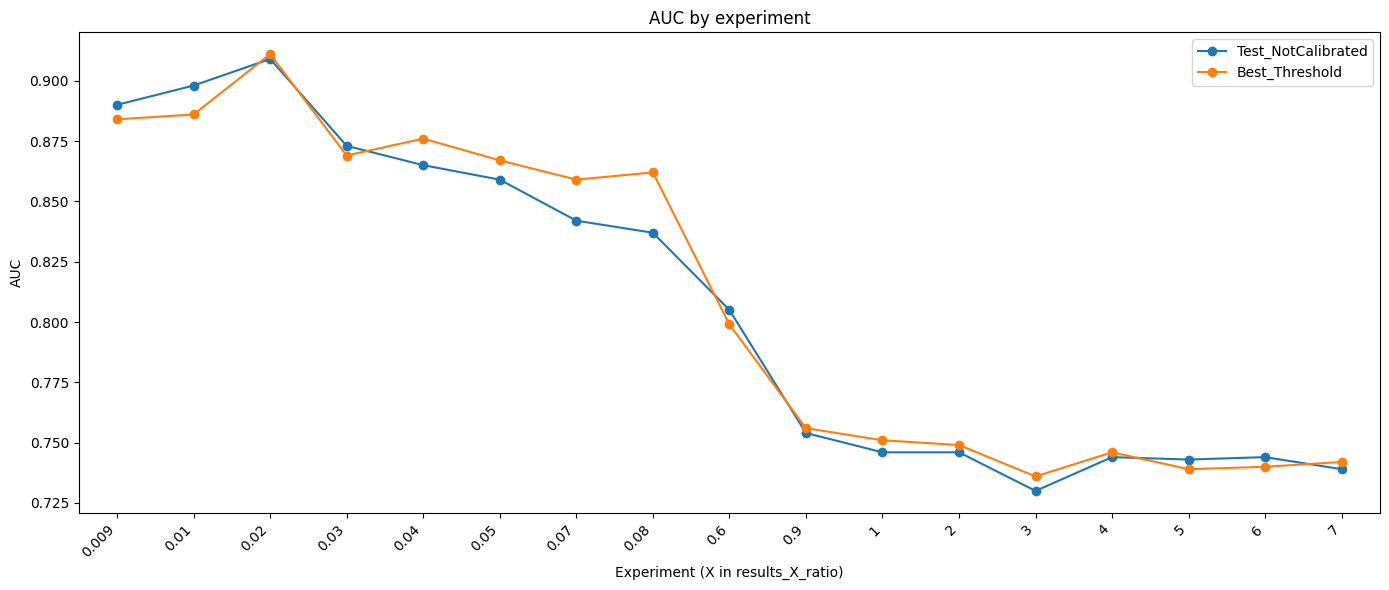

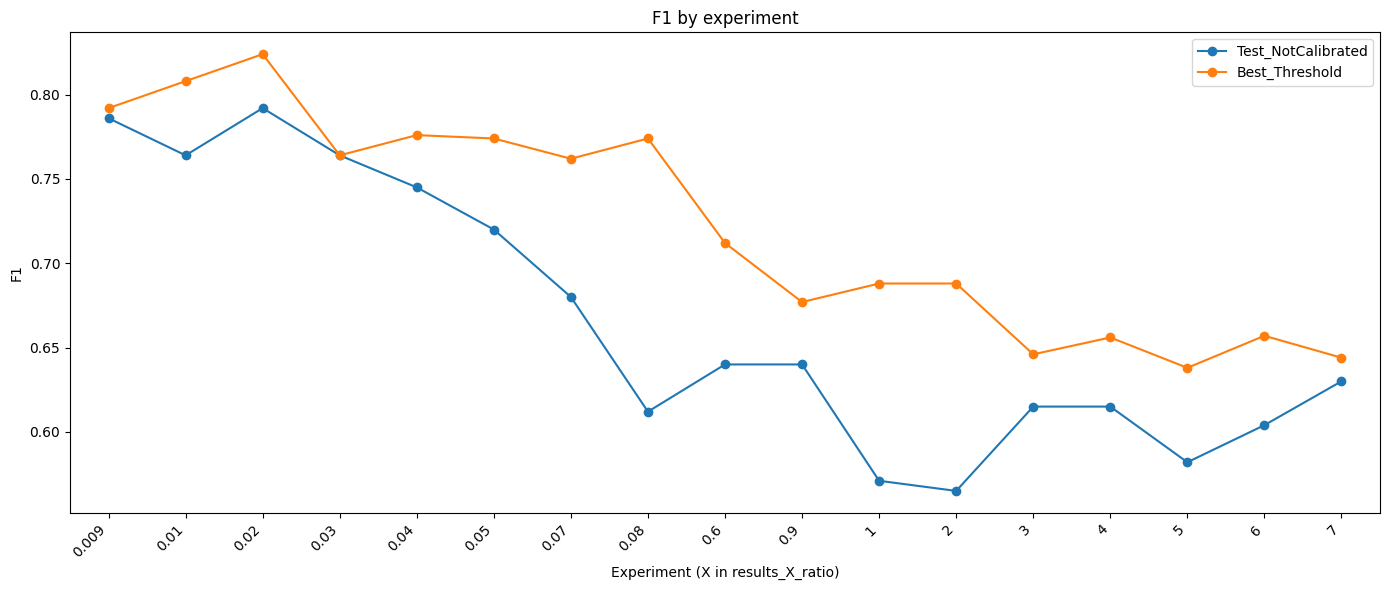

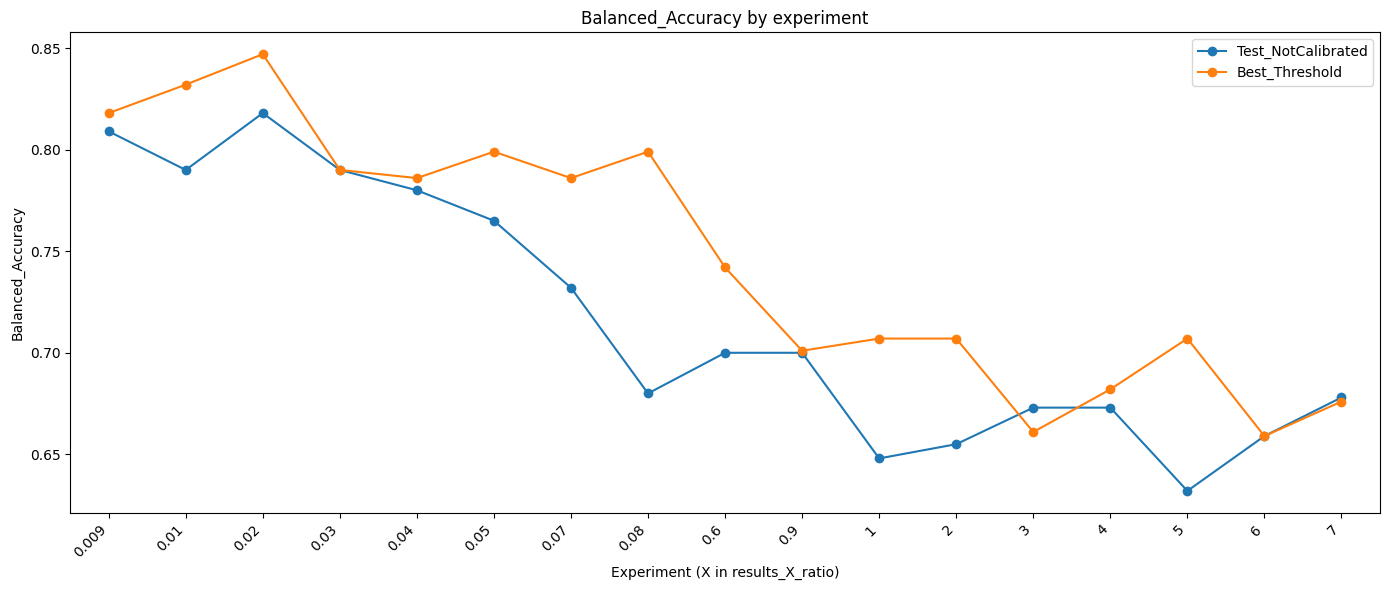

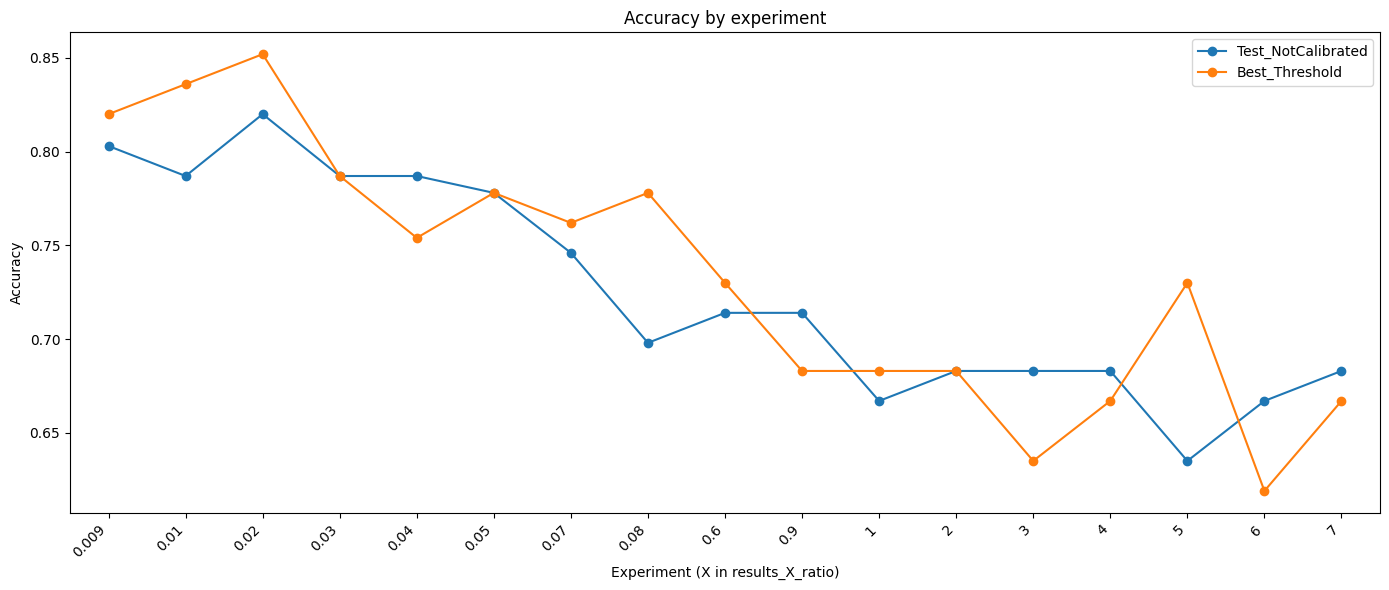

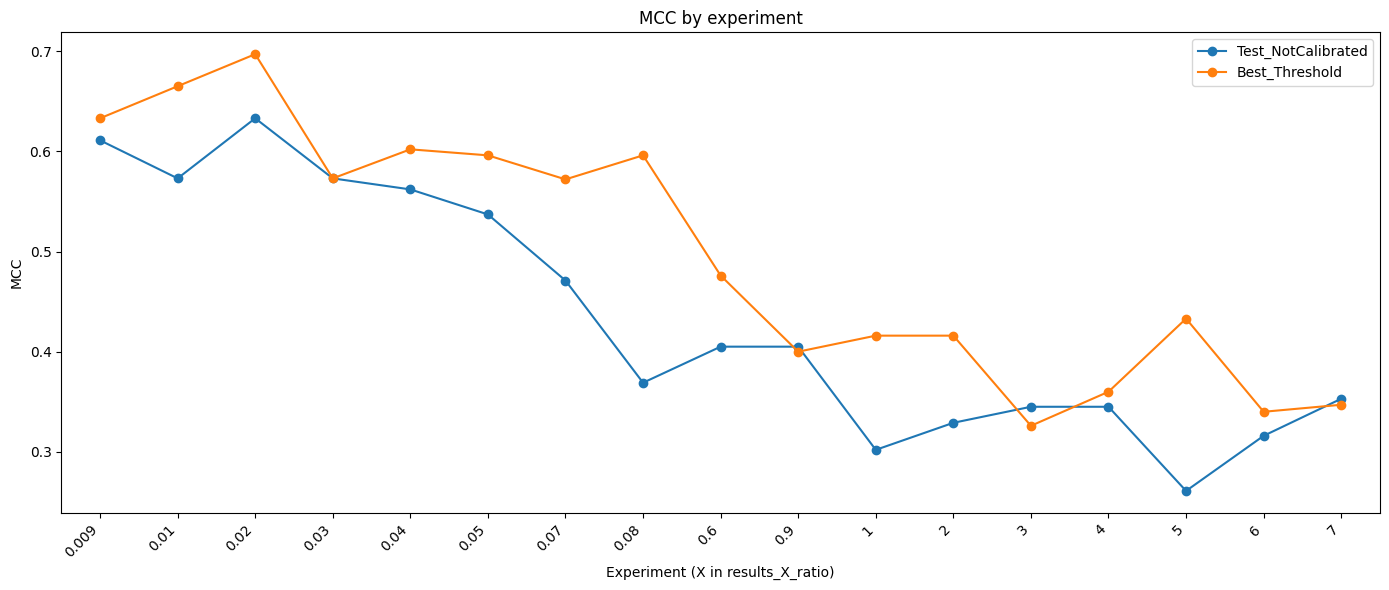

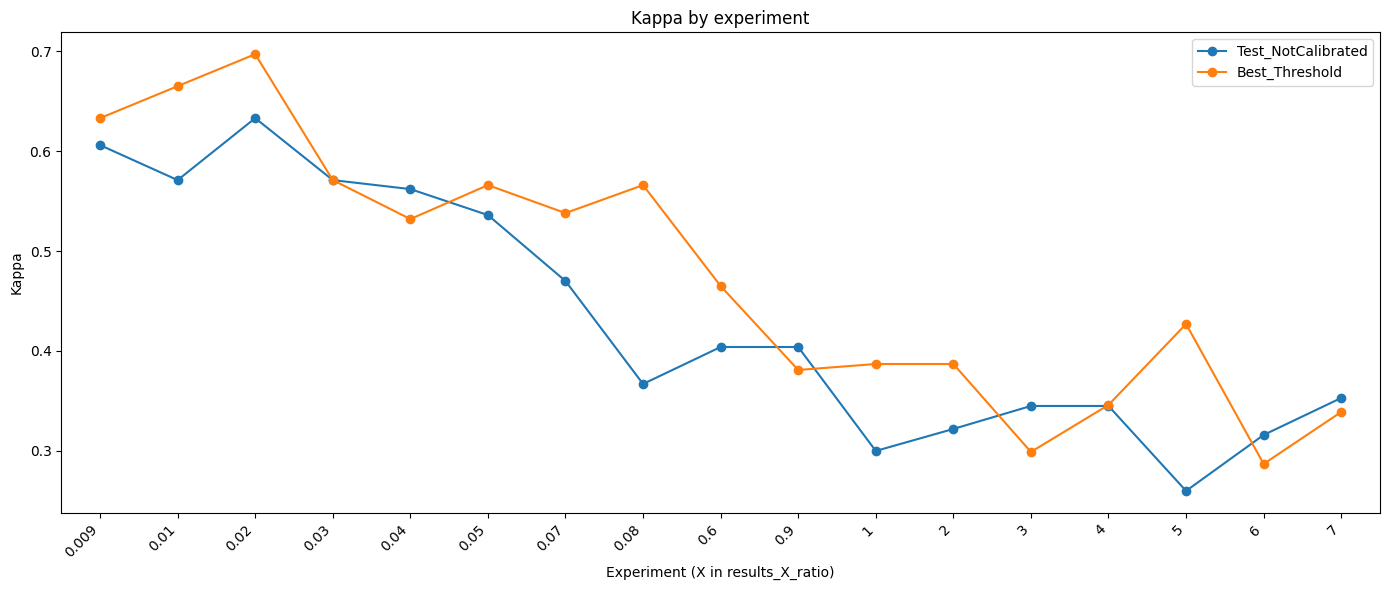

In [63]:
# X-axis categories: positions 1..N and experiment labels
x_positions = [pos_map[lbl] for lbl in experiment_labels]
x_labels = experiment_labels

# (1) AUC, F1, Balanced_Accuracy, Accuracy by experiment (NotCalibrated vs Best_Threshold)
for metric in ["AUC", "F1", "Balanced_Accuracy", "Accuracy","MCC","Kappa"]:
    plt.figure(figsize=(14, 6))
    for section in ["Test_NotCalibrated", "Best_Threshold"]:
        dfp = df_overall[df_overall["Section"] == section].sort_values("Experiment_Pos")
        plt.plot(dfp["Experiment_Pos"], dfp[metric], marker="o", label=section)
    plt.xlabel("Experiment (X in results_X_ratio)")
    plt.xticks(x_positions, x_labels, rotation=45, ha="right")
    plt.xlim(0.5, len(x_positions) + 0.5)
    plt.ylabel(metric)
    plt.title(f"{metric} by experiment")
    plt.legend()
    plt.tight_layout()
    plt.show()


#### Per-class metrics

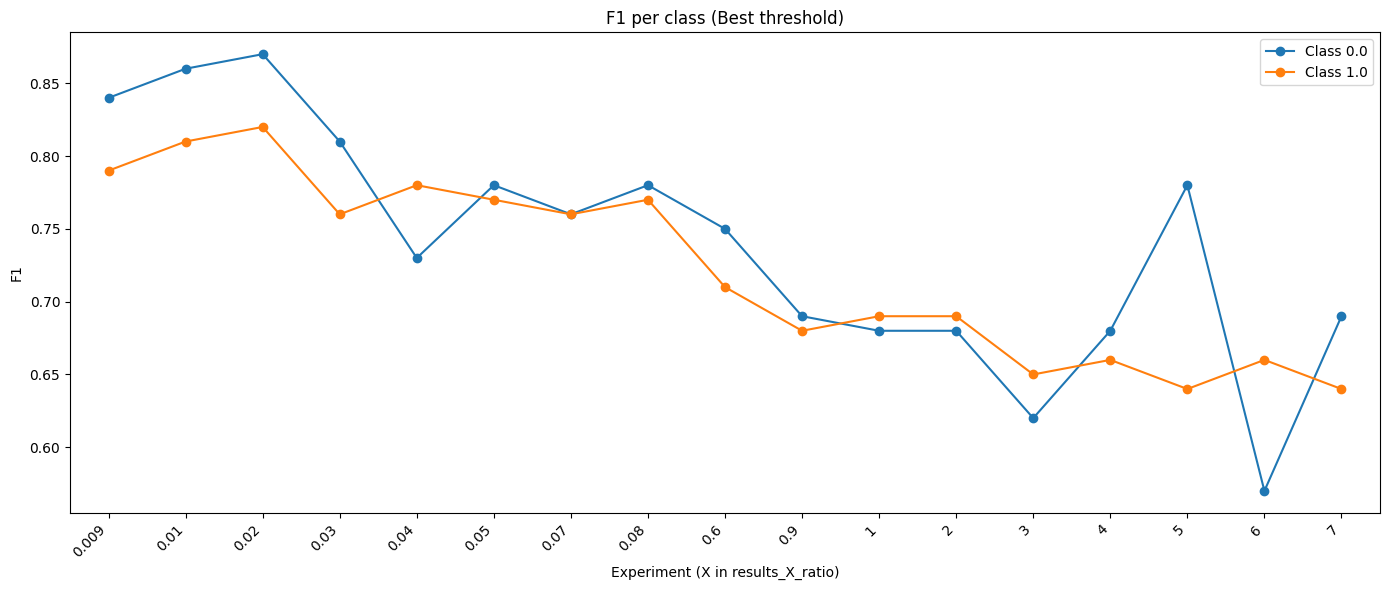

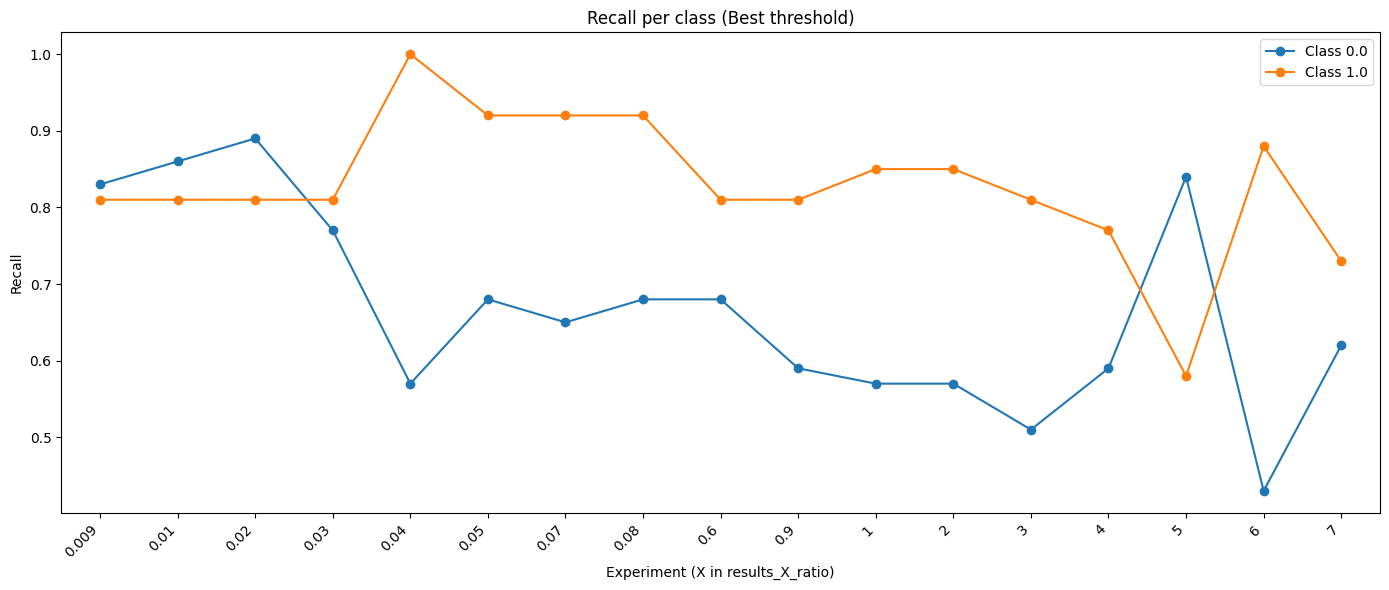

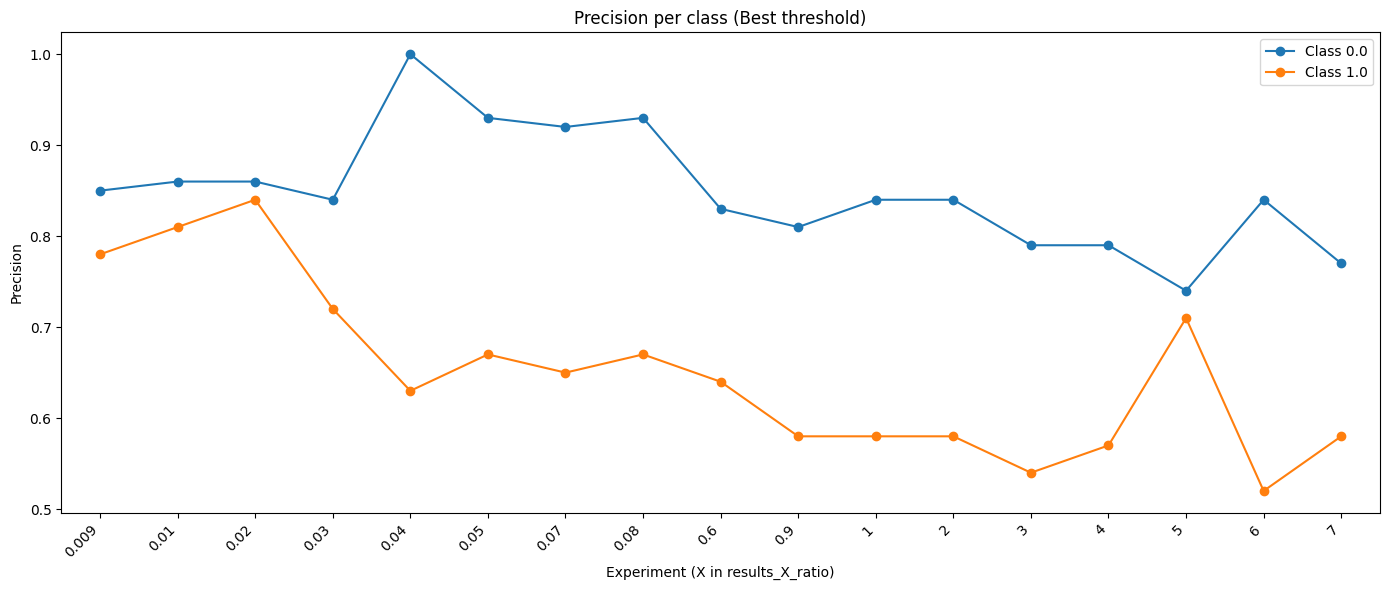

In [64]:
# (2) F1 per class (Best_Threshold)
plt.figure(figsize=(14, 6))
for cls in ["0.0", "1.0"]:
    dfp = (
        df_perclass[(df_perclass["Section"] == "Best_Threshold") & (df_perclass["Class"] == cls)]
        .sort_values("Experiment_Pos")
    )
    plt.plot(dfp["Experiment_Pos"], dfp["F1"], marker="o", label=f"Class {cls}")
plt.xlabel("Experiment (X in results_X_ratio)")
plt.xticks(x_positions, x_labels, rotation=45, ha="right")
plt.xlim(0.5, len(x_positions) + 0.5)
plt.ylabel("F1")
plt.title("F1 per class (Best threshold)")
plt.legend()
plt.tight_layout()
plt.show()

# (3) Recall per class (Best_Threshold)
plt.figure(figsize=(14, 6))
for cls in ["0.0", "1.0"]:
    dfp = (
        df_perclass[(df_perclass["Section"] == "Best_Threshold") & (df_perclass["Class"] == cls)]
        .sort_values("Experiment_Pos")
    )
    plt.plot(dfp["Experiment_Pos"], dfp["Recall"], marker="o", label=f"Class {cls}")
plt.xlabel("Experiment (X in results_X_ratio)")
plt.xticks(x_positions, x_labels, rotation=45, ha="right")
plt.xlim(0.5, len(x_positions) + 0.5)
plt.ylabel("Recall")
plt.title("Recall per class (Best threshold)")
plt.legend()
plt.tight_layout()
plt.show()

# (4) Precision per class (Best_Threshold)
plt.figure(figsize=(14, 6))
for cls in ["0.0", "1.0"]:
    dfp = (
        df_perclass[(df_perclass["Section"] == "Best_Threshold") & (df_perclass["Class"] == cls)]
        .sort_values("Experiment_Pos")
    )
    plt.plot(dfp["Experiment_Pos"], dfp["Precision"], marker="o", label=f"Class {cls}")
plt.xlabel("Experiment (X in results_X_ratio)")
plt.xticks(x_positions, x_labels, rotation=45, ha="right")
plt.xlim(0.5, len(x_positions) + 0.5)
plt.ylabel("Precision")
plt.title("Precision per class (Best threshold)")
plt.legend()
plt.tight_layout()
plt.show()


### Combined calibrated metrics plot (Best threshold)

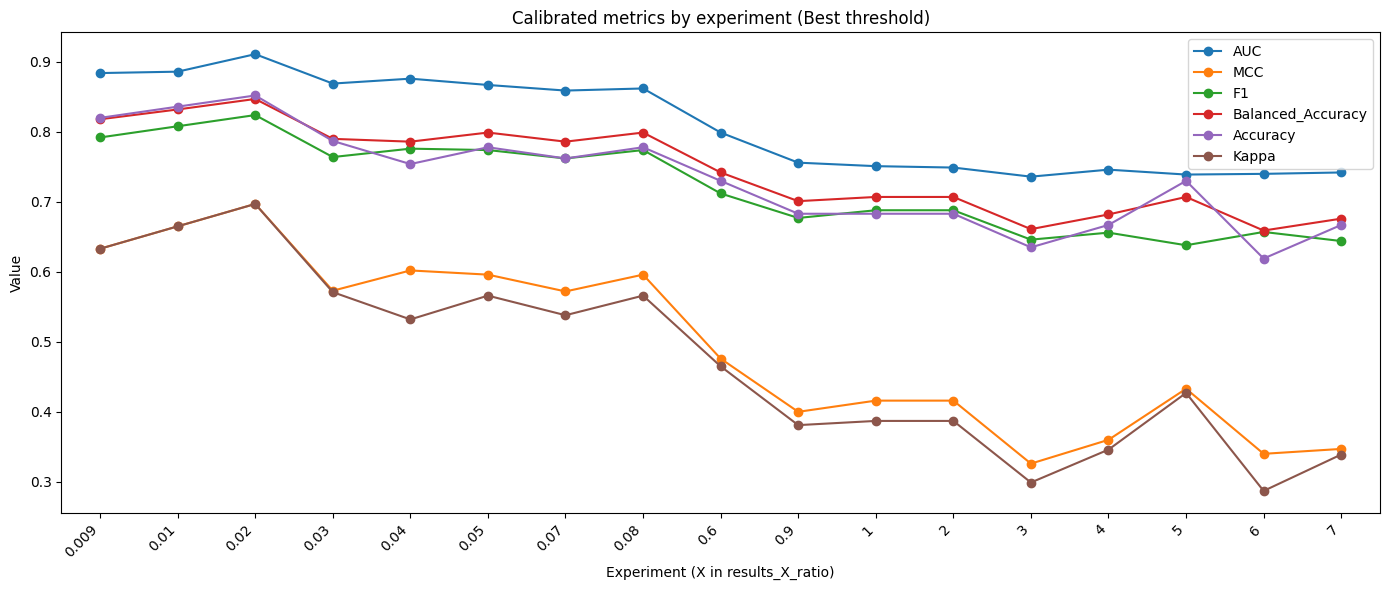

In [65]:
df_cal = df_overall[df_overall["Section"] == "Best_Threshold"].sort_values("Experiment_Pos")
metrics_to_plot = ["AUC", "MCC", "F1", "Balanced_Accuracy", "Accuracy", "Kappa"]

plt.figure(figsize=(14, 6))
for metric in metrics_to_plot:
    plt.plot(df_cal["Experiment_Pos"], df_cal[metric], marker="o", label=metric)

plt.xlabel("Experiment (X in results_X_ratio)")
plt.xticks(x_positions, x_labels, rotation=45, ha="right")
plt.xlim(0.5, len(x_positions) + 0.5)
plt.ylabel("Value")
plt.title("Calibrated metrics by experiment (Best threshold)")
plt.legend()
plt.tight_layout()
plt.show()


## Best Model Selection and plotting

### Set up & Configuration

In [ ]:


def download_freesurfer_color_lut(dest_path: Path) -> None:
    """
    Download the official FreeSurferColorLUT.txt from FreeSurfer GitHub.
    Save it to dest_path (overwriting if exists).
    """
    # URL del LUT en el repositorio de FreeSurfer
    url = "https://raw.githubusercontent.com/freesurfer/freesurfer/dev/distribution/FreeSurferColorLUT.txt"
    resp = requests.get(url)
    resp.raise_for_status()
    # Write to file
    dest_path.parent.mkdir(parents=True, exist_ok=True)
    dest_path.write_text(resp.text, encoding="utf-8")
    print(f"✅ Downloaded FreeSurferColorLUT.txt to {dest_path}")


In [15]:
!conda list -n pyradiomics > environment.yml
!python -m pip freeze > requirements.txt


In [ ]:
# ======== CONFIG ========
# go to the directory where the results are stored
# 
BASE_PATH = Path("./data")

# select the best RATIO in the experimentation
RR = "0.02"
path_vars = (
    BASE_PATH / 
    f"results_{RR}_ratio" / 
    "most_discriminant" / 
    "radiomics_experiment" / 
    "variables_usadas.txt"
)
path_lut  = BASE_PATH.parent /"freesurfer_color_LUT"
download_freesurfer_color_lut(path_lut)

✅ Downloaded FreeSurferColorLUT.txt to src/4_results_viewer/freesurfer_color_LUT


### Generate dataset map

In [9]:
# --- 1) Load selected variables ---
vars_list = [ln.strip() for ln in open(path_vars, encoding="utf-8", errors="ignore") if ln.strip()]
df_vars = pd.DataFrame({"Variable": vars_list})
df_vars["Label_ID"] = df_vars["Variable"].str.extract(r"^label(\d+)_").astype(int)


FileNotFoundError: [Errno 2] No such file or directory: 'src/4_results_viewer/data/results_0.02_ratio/most_discriminant/radiomics_experiment/variables_usadas.txt'

In [22]:


# --- 2) Parse FreeSurfer LUT ---
rows = []
with open(path_lut, encoding="utf-8", errors="ignore") as f:
    for line in f:
        line = line.strip()
        if not line or line.startswith("#"):
            continue
        m = re.match(r"^(\d+)\s+(.+?)\s+(\d+)\s+(\d+)\s+(\d+)\s+(\d+)$", line)
        if m:
            rows.append((int(m.group(1)), m.group(2)))
df_lut = pd.DataFrame(rows, columns=["Label_ID", "FS_Label_Name"])


In [ ]:

# --- 3) Merge variables with LUT ---
df_map = df_vars.merge(df_lut, on="Label_ID", how="left")

total = len(df_map)


In [24]:

# --- Extra: hemisphere and simplified structure ---
def hemi(name):
    if pd.isna(name): return None
    if any(k in name for k in ["ctx-lh", "wm-lh", "Left-"]):  return "LH"
    if any(k in name for k in ["ctx-rh", "wm-rh", "Right-"]): return "RH"
    return "Midline/Other"

def structure(name):
    if pd.isna(name): return None
    if name.startswith(("ctx-lh-","ctx-rh-","wm-lh-","wm-rh-")):
        return name.split("-", 2)[2]
    if name.startswith(("Left-","Right-")):
        return name.split("-", 1)[1]
    return name

df_map["Hemisphere"]   = df_map["FS_Label_Name"].apply(hemi)
df_map["FS_Structure"] = df_map["FS_Label_Name"].apply(structure)


In [57]:

# --- Results ---
print("Mapped variables (first rows):")
display(df_map.head(15))

print("\nCounts by structure (top):")
display(df_map["FS_Structure"].value_counts().head(20))

print("\nCounts by hemisphere:")
display(df_map["Hemisphere"].value_counts(dropna=False))

# (Optional) save to CSV
df_map.to_csv(BASE_PATH / "freesurfer_mapping.csv", index=False)

Mapped variables (first rows):


,Variable,Label_ID,FS_Label_Name,Hemisphere,FS_Structure,Feature_Family
0,label1035_log-sigma-3-0-mm-3D_firstorder_10Per...,1035,ctx-lh-insula,LH,insula,First-order
1,label17_wavelet-HLL_glcm_DifferenceVariance,17,Left-Hippocampus,LH,Hippocampus,Texture – GLCM
2,label17_wavelet-HLL_glcm_Imc1,17,Left-Hippocampus,LH,Hippocampus,Texture – GLCM
3,label17_wavelet-HLL_glcm_DifferenceEntropy,17,Left-Hippocampus,LH,Hippocampus,Texture – GLCM
4,label41_wavelet-LLH_glcm_DifferenceEntropy,41,Right-Cerebral-White-Matter,RH,Cerebral-White-Matter,Texture – GLCM
5,label41_wavelet-LLH_glcm_DifferenceVariance,41,Right-Cerebral-White-Matter,RH,Cerebral-White-Matter,Texture – GLCM
6,label50_wavelet-HHH_firstorder_10Percentile,50,Right-Caudate,RH,Caudate,First-order
7,label41_wavelet-LLH_gldm_LargeDependenceLowGra...,41,Right-Cerebral-White-Matter,RH,Cerebral-White-Matter,Texture – GLDM
8,label2_wavelet-LLH_glcm_DifferenceEntropy,2,Left-Cerebral-White-Matter,LH,Cerebral-White-Matter,Texture – GLCM
9,label41_wavelet-LLH_glrlm_LongRunLowGrayLevelE...,41,Right-Cerebral-White-Matter,RH,Cerebral-White-Matter,Texture – GLRLM



Counts by structure (top):


FS_Structure
superiortemporal           666
Cerebellum-White-Matter    643
Cerebellum-Cortex          582
lateraloccipital           523
precentral                 513
VentralDC                  508
insula                     479
transversetemporal         454
caudalanteriorcingulate    445
posteriorcingulate         427
bankssts                   426
middletemporal             407
superiorfrontal            403
Caudate                    377
postcentral                370
caudalmiddlefrontal        369
lateralorbitofrontal       363
parstriangularis           362
Cerebral-White-Matter      336
medialorbitofrontal        331
Name: count, dtype: int64


Counts by hemisphere:


Hemisphere
LH               7315
RH               6761
Midline/Other    1123
Name: count, dtype: int64

### Plots

#### Plot top structures by hemisphere

In [ ]:
# %% [markdown]
# ### Top-N structures: counts & per-structure percentages (LH / RH / Midline)



def summarize_structures_per_structure_share(
    df_map: pd.DataFrame, top_n: int = 15,
    hemisphere_col: str = "Hemisphere", structure_col: str = "FS_Structure"
):
    """
    Returns:
      - summary: DataFrame with columns [Total, LH, RH, Midline, LH_%, RH_%, Midline_%]
                 where the percentages are *per structure* and add up to 100%.
      - raw_ct: original contingency table (for debugging if necessary).
    Requires df_map to have columns: `structure_col` and `hemisphere_col`.
    """
    df = df_map[[structure_col, hemisphere_col]].dropna(subset=[structure_col])

    #  Normalizes hemisphere values to LH/RH/Midline
    def norm_hemi(h):
        if pd.isna(h):
            return "Midline"
        h = str(h).strip()
        if h in ("LH", "RH"):
            return h
        return "Midline"

    df = df.assign(Hemi=df[hemisphere_col].map(norm_hemi))

    # Counts by (structure, hemi)
    ct = df.groupby([structure_col, "Hemi"]).size().unstack(fill_value=0)

    # Secure columns
    for col in ["LH", "RH", "Midline"]:
        if col not in ct.columns:
            ct[col] = 0

    # Total by structure and Top-N
    ct["Total"] = ct[["LH", "RH", "Midline"]].sum(axis=1)
    top_idx = ct["Total"].sort_values(ascending=False).head(top_n).index
    top = ct.loc[top_idx, ["LH", "RH", "Midline", "Total"]].sort_values("Total", ascending=False)

    # % by structure (total 100%)
    denom = top["Total"].replace(0, np.nan)
    summary = top.copy()
    summary["LH_%"] = (summary["LH"] / denom * 100).fillna(0.0)
    summary["RH_%"] = (summary["RH"] / denom * 100).fillna(0.0)
    summary["Midline_%"] = (summary["Midline"] / denom * 100).fillna(0.0)

    # Kind rounding
    summary = summary.round({"LH_%": 2, "RH_%": 2, "Midline_%": 2})
    return summary, ct


Top-20 structures (counts & per-structure %):


Hemi,LH,RH,Midline,Total,LH_%,RH_%,Midline_%
FS_Structure,,,,,,,
superiortemporal,362,304,0,666,54.35,45.65,0.0
Cerebellum-White-Matter,309,334,0,643,48.06,51.94,0.0
Cerebellum-Cortex,341,241,0,582,58.59,41.41,0.0
lateraloccipital,256,267,0,523,48.95,51.05,0.0
precentral,298,215,0,513,58.09,41.91,0.0
VentralDC,300,208,0,508,59.06,40.94,0.0
insula,239,240,0,479,49.90,50.10,0.0
transversetemporal,199,255,0,454,43.83,56.17,0.0
caudalanteriorcingulate,184,261,0,445,41.35,58.65,0.0


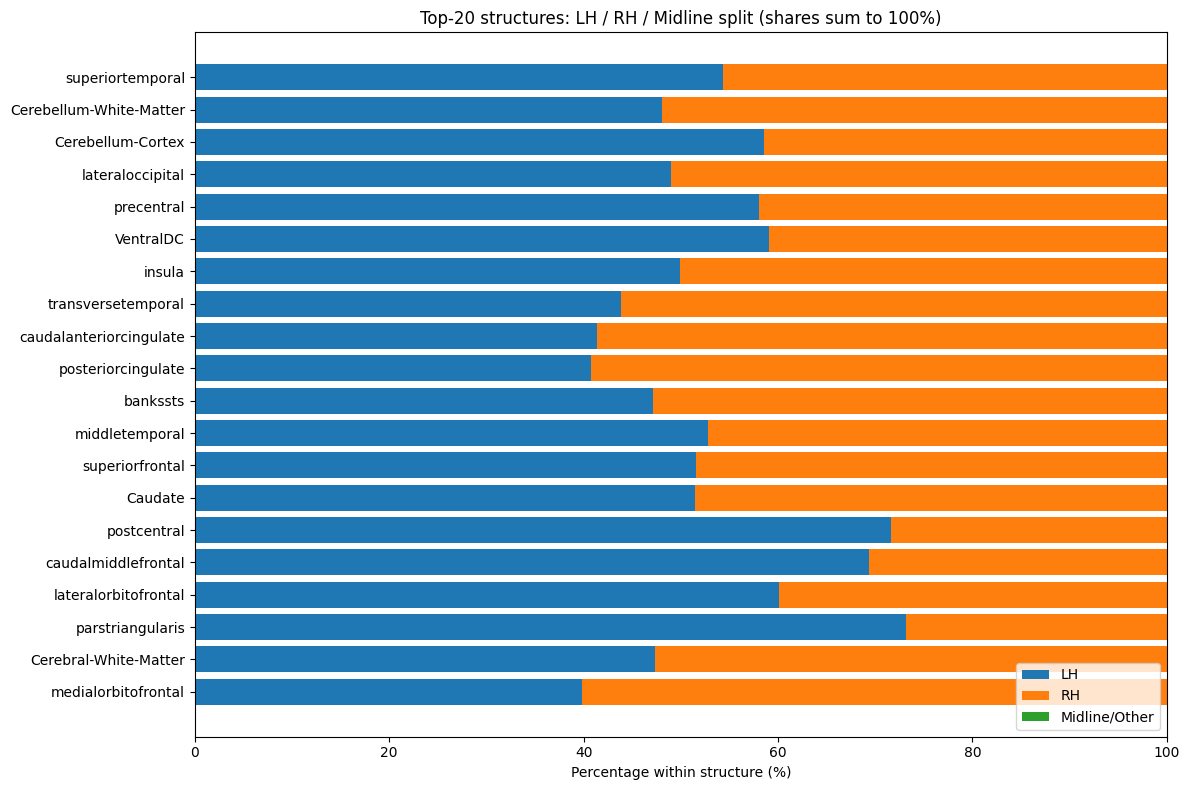

In [81]:

# --- USE ---
# df_map debe existir y tener columnas: ['FS_Structure','Hemisphere'] (como en tu dataframe mapeado)
top_n = 20
summary, _ = summarize_structures_per_structure_share(df_map, top_n=top_n)

print(f"Top-{top_n} structures (counts & per-structure %):")
display(summary)

# --- Gráfico: barras horizontales apiladas (LH / RH / Midline) ---
plt.figure(figsize=(12, max(6, 0.4 * len(summary))))
y_pos = np.arange(len(summary))

# Segmentos (% por estructura que suman 100)
lh = summary["LH_%"].values
rh = summary["RH_%"].values
md = summary["Midline_%"].values

# Barras apiladas
plt.barh(y_pos, lh, label="LH", edgecolor="none")
plt.barh(y_pos, rh, left=lh, label="RH", edgecolor="none")
plt.barh(y_pos, md, left=lh+rh, label="Midline/Other", edgecolor="none")

# Etiquetas
plt.yticks(y_pos, summary.index)
plt.xlabel("Percentage within structure (%)")
plt.xlim(0, 100)
plt.title(f"Top-{top_n} structures: LH / RH / Midline split (shares sum to 100%)")
plt.legend(loc="lower right")

# Invertir eje Y para que el más frecuente quede arriba
plt.gca().invert_yaxis()

plt.tight_layout()
plt.show()



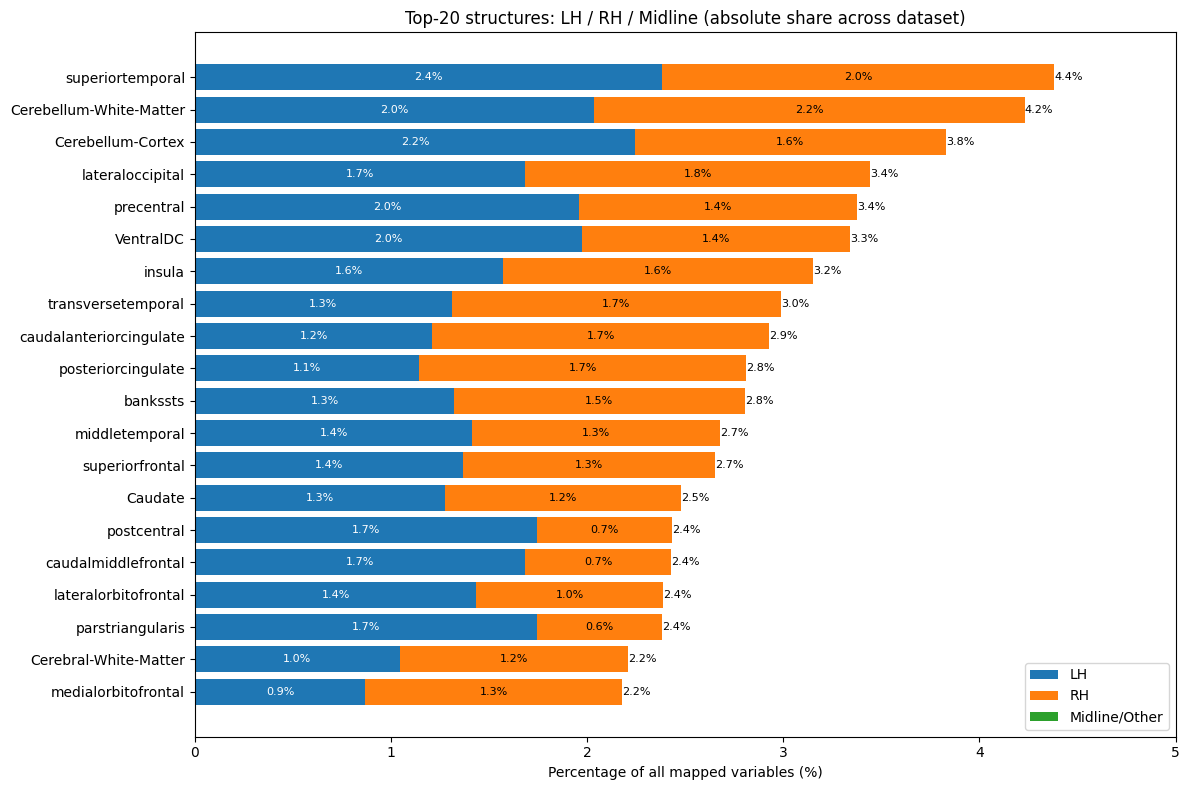

In [82]:


# --- Chart: stacked horizontal bars (LH / RH / Midline) in ABSOLUTE ---
plt.figure(figsize=(12, max(6, 0.4 * len(summary))))
y_pos = np.arange(len(summary))

# Absolute segments (% of global total)
lh_abs = 100 * summary["LH"] / total
rh_abs = 100 * summary["RH"] / total
md_abs = 100 * summary["Midline"] / total

# Stacked horizontal bars
plt.barh(y_pos, lh_abs, label="LH", edgecolor="none")
plt.barh(y_pos, rh_abs, left=lh_abs, label="RH", edgecolor="none")
plt.barh(y_pos, md_abs, left=lh_abs + rh_abs, label="Midline/Other", edgecolor="none")

# Labels
plt.yticks(y_pos, summary.index)
plt.xlabel("Percentage of all mapped variables (%)")
plt.xlim(0, 5)
plt.title(f"Top-{top_n} structures: LH / RH / Midline (absolute share across dataset)")
plt.legend(loc="lower right")

# Annotate percentages
for i, (lh, rh, md) in enumerate(zip(lh_abs, rh_abs, md_abs)):
    if lh > 0:
        plt.text(lh / 2, i, f"{lh:.1f}%", ha="center", va="center", color="white", fontsize=8)
    if rh > 0:
        plt.text(lh + rh / 2, i, f"{rh:.1f}%", ha="center", va="center", color="Black", fontsize=8)
    if md > 0:
        plt.text(lh + rh + md / 2, i, f"{md:.1f}%", ha="center", va="center", color="Black", fontsize=8)
    plt.text(lh + rh + md, i, f"{lh + rh + md:.1f}%", ha="left", va="center", color="Black", fontsize=8)

# Invert y-axis
plt.gca().invert_yaxis()

plt.tight_layout()
plt.show()



#### Plot Tranfomations

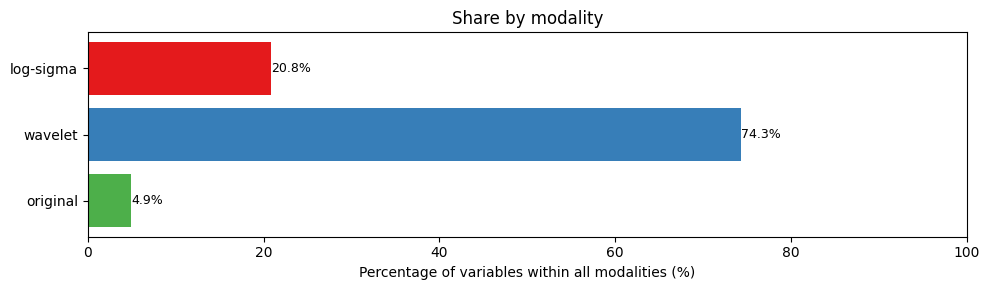

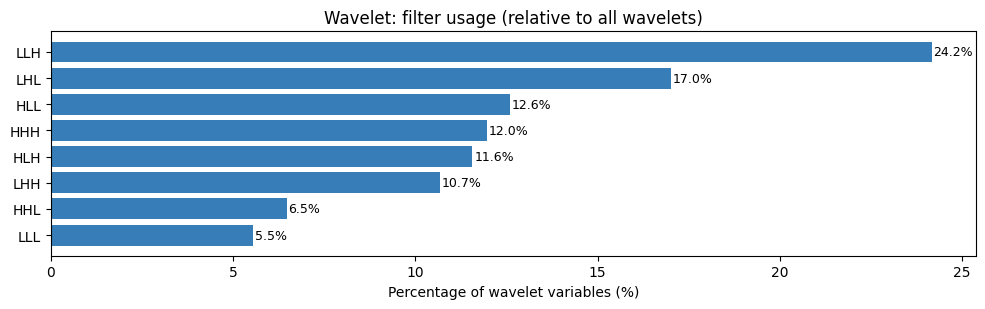

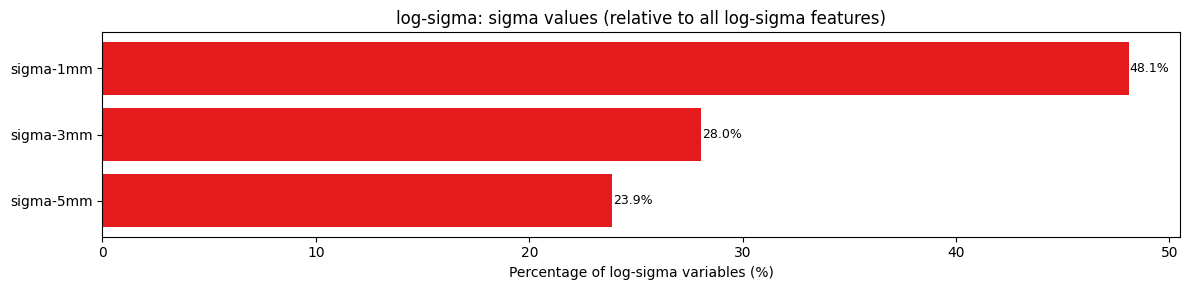

In [ ]:


# === Base colors (consistent palette) ===
colors = {
    "log-sigma": "#E41A1C",   # rojo
    "wavelet":   "#377EB8",   # azul
    "original":  "#4DAF4A",   # verde
    "other":     "#999999"    # gris (por si aparece)
}

# === 1) Modalidad (log-sigma / wavelet / original) ===
mods = df_map["Variable"].astype(str).apply(
    lambda v: "log-sigma" if "log-sigma" in v.lower()
    else "wavelet" if "wavelet-" in v.lower()
    else "original" if "original" in v.lower()
    else "other"
)

mod_counts = mods.value_counts().reindex(["log-sigma", "wavelet", "original"]).fillna(0).astype(int)
total_mod = mod_counts.sum()
mod_perc = 100 * mod_counts / total_mod

plt.figure(figsize=(10, max(3, 0.4 * len(mod_perc))))
y = np.arange(len(mod_perc))
plt.barh(y, mod_perc.values, color=[colors[m] for m in mod_perc.index])
plt.yticks(y, mod_perc.index)
plt.xlabel("Percentage of variables within all modalities (%)")
plt.title("Share by modality")
plt.gca().invert_yaxis()
plt.xlim(0, 100)
for yi, val in enumerate(mod_perc.values):
    plt.text(val + 0.05, yi, f"{val:.1f}%", va="center", fontsize=9)
plt.tight_layout()
plt.show()


# === 2) Wavelet filters ===
def wavelet_filter(v: str):
    m = re.search(r"wavelet-([hl]{3})[_-]", v.lower())
    return m.group(1).upper() if m else None

wavelet_vars = df_map.loc[mods.eq("wavelet"), "Variable"].astype(str)
wavelet_tags = wavelet_vars.apply(wavelet_filter).dropna()

tag_counts = wavelet_tags.value_counts().sort_values(ascending=False)
total_wavelets = tag_counts.sum()
tag_perc = 100 * tag_counts / total_wavelets

plt.figure(figsize=(10, max(3, 0.4 * len(tag_counts))))
y = np.arange(len(tag_counts))
plt.barh(y, tag_perc.values, color=colors["wavelet"])
plt.yticks(y, tag_counts.index)
plt.xlabel("Percentage of wavelet variables (%)")
plt.title("Wavelet: filter usage (relative to all wavelets)")
plt.gca().invert_yaxis()
for yi, val in enumerate(tag_perc.values):
    plt.text(val + 0.05, yi, f"{val:.1f}%", va="center", fontsize=9)
plt.tight_layout()
plt.show()


# === 3) Sigma buckets ===
def sigma_from_var(v: str):
    if "log-sigma" not in v.lower():
        return None
    m = re.search(r"log-sigma-([0-9]+(?:-[0-9]+)?)\-?mm", v.lower())
    if not m:
        return None
    raw = m.group(1)
    if "-" in raw:
        parts = raw.split("-")
        raw = f"{parts[0]}.{parts[1]}"
    try:
        val = float(raw)
        val = int(val) if val.is_integer() else val
    except Exception:
        return None
    return f"sigma-{val}mm"

sigma_vars = df_map.loc[mods.eq("log-sigma"), "Variable"].astype(str)
sigma_tags = sigma_vars.apply(sigma_from_var).dropna()

sigma_counts = sigma_tags.value_counts().sort_index(
    key=lambda idx: [float(re.search(r"([0-9.]+)", s).group()) for s in idx]
)
total_sigmas = sigma_counts.sum()
sigma_perc = 100 * sigma_counts / total_sigmas

plt.figure(figsize=(12, max(3, 0.4 * len(sigma_counts))))
y = np.arange(len(sigma_counts))
plt.barh(y, sigma_perc.values, color=colors["log-sigma"])
plt.yticks(y, sigma_counts.index)
plt.xlabel("Percentage of log-sigma variables (%)")
plt.title("log-sigma: sigma values (relative to all log-sigma features)")
plt.gca().invert_yaxis()
for yi, val in enumerate(sigma_perc.values):
    plt.text(val + 0.05, yi, f"{val:.1f}%", va="center", fontsize=9)
plt.tight_layout()
plt.show()


#### Plot Families of radiomics variables

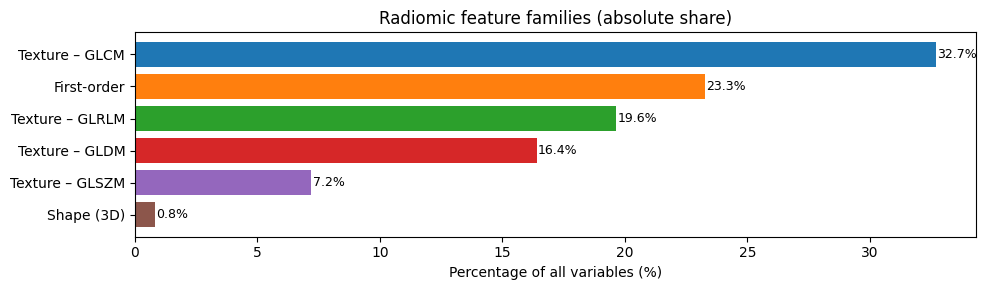

In [66]:
# === Radiomic families ===
def feature_group(name: str) -> str | None:
    n = str(name).lower()
    if re.search(r'(^|[_-])shape3?d?[_-]', n):   return "Shape (3D)"
    if re.search(r'(^|[_-])firstorder[_-]', n):   return "First-order"
    if re.search(r'(^|[_-])glcm[_-]', n):        return "Texture – GLCM"
    if re.search(r'(^|[_-])glrlm[_-]', n):       return "Texture – GLRLM"
    if re.search(r'(^|[_-])glszm[_-]', n):       return "Texture – GLSZM"
    if re.search(r'(^|[_-])ngtdm[_-]', n):       return "Texture – NGTDM"
    if re.search(r'(^|[_-])gldm[_-]', n):        return "Texture – GLDM"
    return "Other"

# Map family
df_map["Feature_Family"] = df_map["Variable"].apply(feature_group)

# Counts & percentages
fam_counts = df_map["Feature_Family"].value_counts()
total = len(df_map)
fam_perc = 100 * fam_counts / total

# Palette
colors = plt.cm.tab10.colors  # categorical palette
color_map = {fam: colors[i % len(colors)] for i, fam in enumerate(fam_perc.index)}

# Plot
plt.figure(figsize=(10, max(3, 0.5 * len(fam_perc))))
y = np.arange(len(fam_perc))
bars = plt.barh(y, fam_perc.values, color=[color_map[f] for f in fam_perc.index])

plt.yticks(y, fam_perc.index)
plt.xlabel("Percentage of all variables (%)")
plt.title("Radiomic feature families (absolute share)")
plt.gca().invert_yaxis()

# Annotate
for bar, val in zip(bars, fam_perc.values):
    plt.text(bar.get_width() + 0.05, bar.get_y() + bar.get_height()/2,
             f"{val:.1f}%", va="center", fontsize=9)

plt.tight_layout()
plt.show()
